In [6]:
import lsst.cp.pipe as cpPipe

print(cpPipe.__file__)
import lsst.ip.isr as ipIsr
print(ipIsr.__file__)
from lsst.ip.isr.isrTask import IsrTask

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy
from tqdm import tqdm

import os
import lsst.cp.pipe as cpPipe
import itertools
from matplotlib.colors import LogNorm
import traceback
import pylab
import json
from astropy.time import Time
from lsst.cp.pipe.makeBrighterFatterKernel import BrighterFatterKernelSolveTask, BrighterFatterKernelSolveConfig

import logging
logging.getLogger().setLevel(logging.ERROR)
from time import sleep
from tqdm import tqdm
from astropy.io import fits


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/cp_pipe/gdf35531ce4+5f6e62dbe4/python/lsst/cp/pipe/__init__.py
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ip_isr/g5692000587+aee6f2001b/python/lsst/ip/isr/__init__.py


In [3]:
repo_path = "/repo/ir2"
butler = Butler(repo_path,collections=['LSSTCam/photodiode','LSSTCam/raw/all'],instrument='LSSTCam')
registry = butler.registry

Text(0, 0.5, 'PD current [A]')

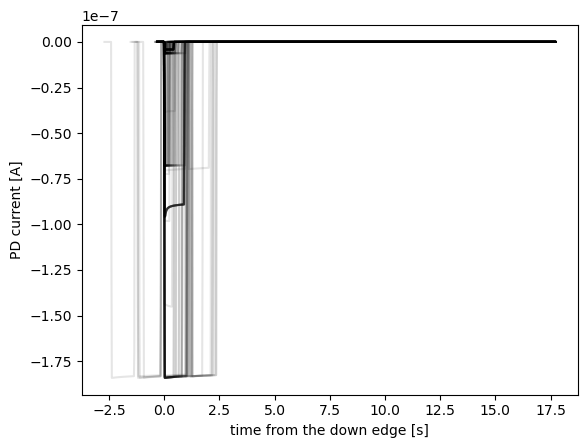

In [74]:
where = "exposure.science_program = '13505' and detector=122"
refs = list(set(butler.registry.queryDatasets('photodiode', where=where)))
for ref in refs:
    pd_data = butler.get(ref)
#    print(ref.dataId['exposure'], min(pd_data.currentSamples), max(pd_data.currentSamples))
    start= numpy.argmin(numpy.diff(pd_data.currentSamples))
#    start=numpy.argmin(pd_data.currentSamples)
    plt.plot(pd_data.timeSamples-start*0.0167,pd_data.currentSamples,alpha=0.1,color="k")
#pylab.xlim(-0.1,0.55)
pylab.xlabel("time from the down edge [s]")
pylab.ylabel("PD current [A]")
#pylab.ylim(0.0e-9,0.03e-9)


Text(0, 0.5, 'PD current [A]')

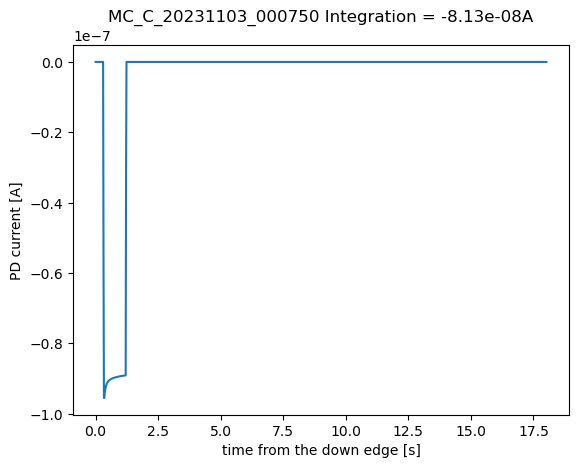

In [116]:
where = "exposure.science_program = '13505' and detector=122"

refs = list(set(butler.registry.queryDatasets('photodiode', where=where)))
aref=refs[0]
pd_data = butler.get(aref)

plt.plot(pd_data.timeSamples,pd_data.currentSamples)
pylab.title(f"{pd_data.getMetadata()['OBSID']} Integration = {pd_data.integrateDirectSum():.2e}A")
pylab.xlabel("time from the down edge [s]")
pylab.ylabel("PD current [A]")


In [12]:
sensor="R10_S01"
list(registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id

28

In [17]:
registry.queryDatasetTypes("*post*")

[DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)]

In [14]:
where = "exposure.science_program = '13549' and detector=28 and exposure.observation_type='flat'"

#    del img

100%|██████████| 234/234 [02:38<00:00,  1.48it/s]


[]

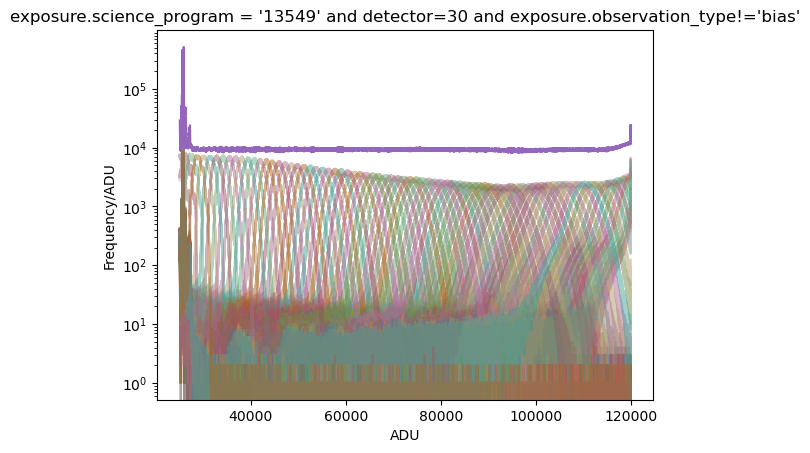

In [15]:

where = "exposure.science_program = '13549' and detector=30 and exposure.observation_type!='bias'"

refs = list(set(butler.registry.queryDatasets('raw', where=where)))

histarr = []
binsarr = []

for ref in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    img=butler.get(ref)
    hist,bins=numpy.histogram(img.image.array,range=(25e3,120e3),bins=95000)
    histarr.append(hist)
    binsarr.append(bins)
    pylab.plot((bins[1:]+bins[:-1])/2,hist,alpha=0.2)
    del img

pylab.plot((bins[1:]+bins[:-1])/2,numpy.sum(histarr,axis=0)/4)

pylab.title(where)
#pylab.ylim(0,20000)
pylab.xlabel("ADU")
pylab.ylabel("Frequency/ADU")
pylab.semilogy()

In [ ]:
pylab.plot((bins[1:]+bins[:-1])/2,numpy.abs(numpy.sum(histarr,axis=0)-numpy.median(numpy.sum(histarr,axis=0)))/numpy.median(numpy.sum(histarr,axis=0)))
pylab.ylim(0,0.1)

In [55]:
collections = butler.registry.queryCollections("*", datasetType="postISRCCD")

where = "instrument = 'LSSTCam' and exposure.day_obs > 20231026  and detector=30"

refs = list(set(butler.registry.queryDatasets('postISRCCD', where=where, collections=collections)))
len(refs)

1000

In [56]:
list(registry.queryDimensionRecords('exposure'))[0]

exposure.RecordClass(instrument='LSST-TS8', id=202210262140050, physical_filter='unknown', obs_id='TS_C_20221026_000001', exposure_time=14.86, dark_time=3.043, observation_type='spot', observation_reason='spot_flat', day_obs=20221026, seq_num=1, seq_start=None, seq_end=None, group_name='202210262140050', group_id=202210262140050, target_name='UNKNOWN', science_program='7119D', tracking_ra=None, tracking_dec=None, sky_angle=None, azimuth=None, zenith_angle=None, has_simulated=None, timespan=Timespan(begin=astropy.time.Time('2022-10-26 21:40:42.054989', scale='tai', format='iso'), end=astropy.time.Time('2022-10-26 21:40:56.914989', scale='tai', format='iso')))

In [230]:
import fsspec
fsspec.__version__

'2023.10.0'

In [177]:
import logging
logging.getLogger().setLevel(logging.ERROR)
from time import sleep
from tqdm import tqdm
from astropy.io import fits

collections = butler.registry.queryCollections("*", datasetType="postISRCCD")

where = "instrument = 'LSSTCam' and exposure.day_obs > 20231026" # and detector=30"

refs = list(set(butler.registry.queryDatasets('postISRCCD', where=where, collections=collections)))
len(refs)

fsspec_kwargs = {
    "default_block_size": 100000,
    "default_cache_type": "bytes",
    "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
}

mjd = []
noises = {}
for ref in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    try:
        with fits.open(butler.getURI(ref).geturl(),use_fsspec=True,
              fsspec_kwargs = fsspec_kwargs
             ) as fh:
            md = fh[0].header
            for key in md['LSST ISR OVERSCAN RESIDUAL SERIAL STDEV*']:
                sensor=f'{md["RAFTBAY"]}/{md["CCDSLOT"]}'
                noises.setdefault(sensor,{}).setdefault(key, [] ).append( md[key] )
            mjd.append(md['MJD'])
    except:
        pass

  4%|▍         | 56364/1349204 [52:46<32:19:14, 11.11it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1349204/1349204 [3:56:51<00:00, 94.94it/s]   


In [210]:
from astropy.table import vstack
stdarry = vstack([ Table(rows=[ { "sensor": sensor, "amp": amp, "std": numpy.std(noises[sensor][amp]) } for amp in noises[sensor] ]) for sensor in noises ])

In [213]:
stdarry.sort("std")

 sensor                     amp                             std         
------- ------------------------------------------- --------------------
R43/S12 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C13 0.013374410313448343
R23/S01 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10   0.0144074558561834
R42/S10 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11  0.01442853388447732
R42/S10 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C01 0.014431743246334549
R03/S21 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C00 0.015125223340742552
 sensor                     amp                            std        
------- ------------------------------------------- ------------------
R24/S11 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C12 3.1023893784708743
R44/SG0 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C02  7.456751661380285
R41/S21 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C02  7.679448742502969
R10/S01 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C03   8.43895170381707
R40/SG1 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10 13.06066174

In [214]:
print(stdarry[:10])
print(stdarry[-10:])

 sensor                     amp                             std         
------- ------------------------------------------- --------------------
R43/S12 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C13 0.013374410313448343
R23/S01 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10   0.0144074558561834
R42/S10 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11  0.01442853388447732
R42/S10 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C01 0.014431743246334549
R03/S21 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C00 0.015125223340742552
R42/S11 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C16 0.015241939424053908
R10/S21 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C15 0.015318388335010653
R43/S22 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C02 0.015323782378874934
R43/S22 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C15 0.015436237105483218
R43/S22 LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C00 0.015505824107133019
 sensor                     amp                            std        
------- ------------------------------------------- -

[]

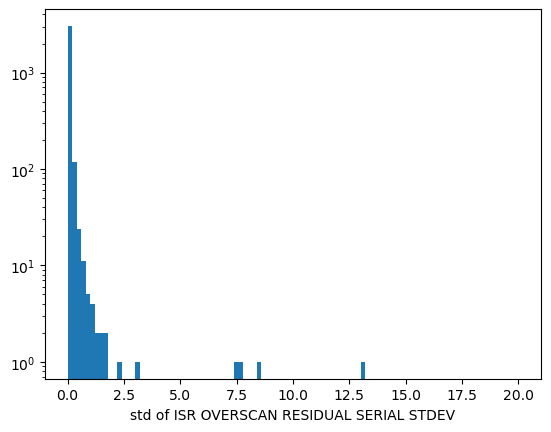

In [223]:
pylab.hist(stdarry["std"],bins=100,range=(0,20))
pylab.xlabel("std of ISR OVERSCAN RESIDUAL SERIAL STDEV")
pylab.semilogy()

Text(0, 0.5, 'ISR OVERSCAN RESIDUAL SERIAL STDEV')

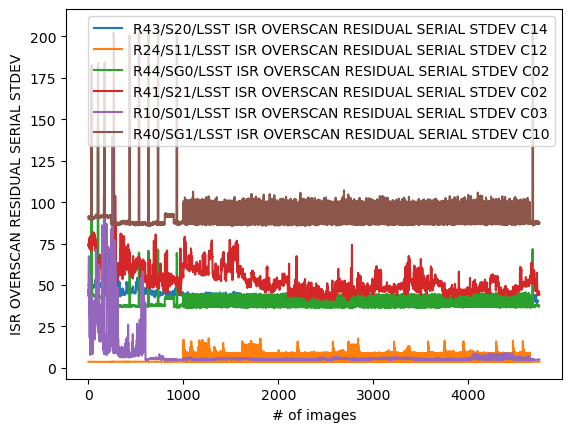

In [226]:
for sensor, amp, std in stdarry[-6:]:
    pylab.plot( noises[sensor][amp],label=f"{sensor}/{amp}")
pylab.legend(fontsize=10)
pylab.xlabel("# of images")
pylab.ylabel("ISR OVERSCAN RESIDUAL SERIAL STDEV")

Text(0, 0.5, 'ISR OVERSCAN RESIDUAL SERIAL STDEV')

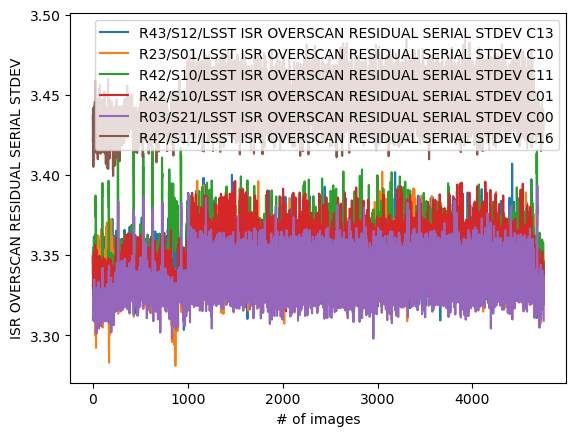

In [227]:
for sensor, amp, std in stdarry[:6]:
    pylab.plot( noises[sensor][amp],label=f"{sensor}/{amp}")
pylab.legend(fontsize=10)
pylab.xlabel("# of images")
pylab.ylabel("ISR OVERSCAN RESIDUAL SERIAL STDEV")

LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10


ValueError: x and y must have same first dimension, but have shapes (975284,) and (4751,)

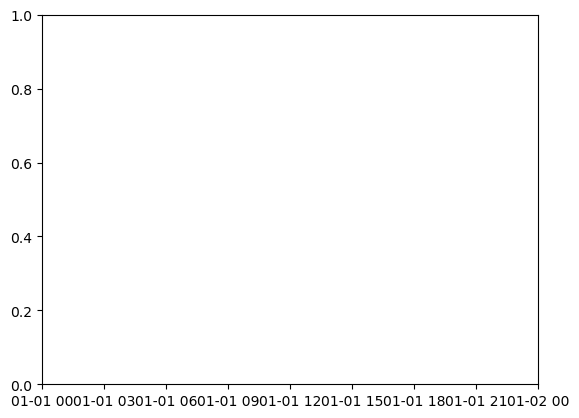

In [178]:
for n_sensor in noises:
    for n_amp in noises[n_sensor]:
        print(n_amp)
        pylab.plot([ Time(m,format='mjd').datetime for m in mjd ], noises[n_sensor][n_amp],"o")

pylab.xticks( rotation='vertical')


(array([19661., 19662., 19664., 19666., 19668., 19670., 19672., 19674.,
        19676., 19678.]),
 [Text(19661.0, 0, '2023-10-31'),
  Text(19662.0, 0, '2023-11-01'),
  Text(19664.0, 0, '2023-11-03'),
  Text(19666.0, 0, '2023-11-05'),
  Text(19668.0, 0, '2023-11-07'),
  Text(19670.0, 0, '2023-11-09'),
  Text(19672.0, 0, '2023-11-11'),
  Text(19674.0, 0, '2023-11-13'),
  Text(19676.0, 0, '2023-11-15'),
  Text(19678.0, 0, '2023-11-17')])

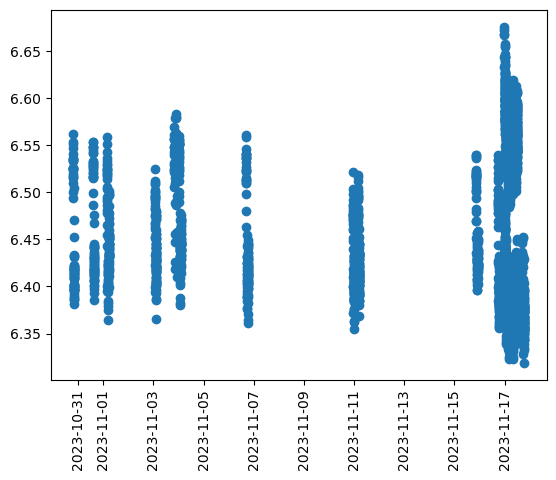

In [118]:
pylab.plot([ Time(m,format='mjd').datetime for m in mjd ],noise,"o")


In [121]:
refs = list(set(butler.registry.queryDatasets('postISRCCD.metadata', where=where, collections=collections)))

mjd = []
noise = []
for datasetRef in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    try:
        md = butler.get(datasetRef)
        noise.append(md['LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C03'])
        mjd.append(md['MJD'])
    except:
        raise

100%|██████████| 6574/6574 [00:40<00:00, 161.18it/s]


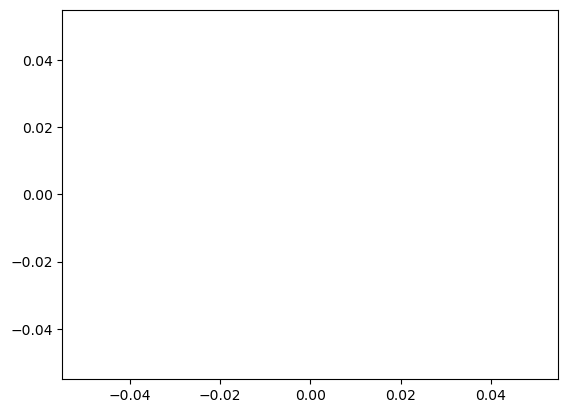

In [109]:
pylab.plot(mjd,noise,"o")

In [95]:
refs = butler.registry.queryDatasets("postISRCCD.metadata", where=where, collections=collections)

mjd = []
noise = []
for datasetRef in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    md = butler.get(ref.makeComponentRef("metadata"))
    noise.append(md['LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C03'])
    mjd.append(md['MJD'])    

100%|██████████| 1000/1000 [00:05<00:00, 178.55it/s]


In [ ]:
refs = butler.registry.queryDatasets("postISRCCD.metadata", where=where, collections=collections)

mjd = []
noise = []
for datasetRef in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    md = butler.get(ref.makeComponentRef("metadata"))
    noise.append(md['LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C03'])
    mjd.append(md['MJD'])    

In [ ]:
print(img1.getMetadata()['LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11'])

In [ ]:
list(registry.queryDimensionRecords("exposure",instrument='LSSTCam'))[0]

In [170]:
import glob

In [172]:
files = glob.glob("os/*json")

In [187]:
from astropy.io import ascii
proto = []
for file in files:
    try:
        with open(file) as f:
            proto.append(json.load(f))
    except:
        pass

In [192]:
table=Table(proto)
table.colnames

['SIMPLE',
 'EXTEND',
 'DATE',
 'MJD',
 'RUNNUM',
 'CCD_MANU',
 'CCD_TYPE',
 'TESTTYPE',
 'IMGTYPE',
 'DETSIZE',
 'EXPTIME',
 'FILENAME',
 'BINX',
 'BINY',
 'CCDGAIN',
 'CCDNOISE',
 'DATE-OBS',
 'MJD-OBS',
 'DATE-TRG',
 'MJD-TRG',
 'IMAGETAG',
 'CCDSLOT',
 'RAFTBAY',
 'FIRMWARE',
 'PLATFORM',
 'CONTNUM',
 'DAQVERS',
 'DAQPART',
 'DAQFOLD',
 'OBSANNOT',
 'OBSID',
 'CAMCODE',
 'CONTRLLR',
 'DAYOBS',
 'SEQNUM',
 'HEADVER',
 'INSTRUME',
 'TELESCOP',
 'TSTAND',
 'SEQFILE',
 'SEQCKSUM',
 'LSST_NUM',
 'CCD_SERN',
 'REBNAME',
 'RAFTNAME',
 'DARKTIME',
 'TSEQNUM',
 'FPVERS',
 'IHVERS',
 'DATE-BEG',
 'MJD-BEG',
 'DATE-END',
 'MJD-END',
 'TIMESYS',
 'FILTER',
 'FILTER1',
 'FILTER2',
 'TEMPLED1',
 'TEMPLED2',
 'TEMPBRD',
 'CCOBLED',
 'CCOBCURR',
 'CCOBADC',
 'CCOBFLST',
 'PROJTIME',
 'CCOBFLUX',
 'DATEPBEG',
 'MJDPBEG',
 'DATEPEND',
 'MJDPEND',
 'CATKW101',
 'CATKW102',
 'CATKW103',
 'CATKW104',
 'CATKW105',
 'CATKW106',
 'CATKW107',
 'CATKW108',
 'CATKW109',
 'CATKW10A',
 'CATKW10B',
 'CATKW10C',

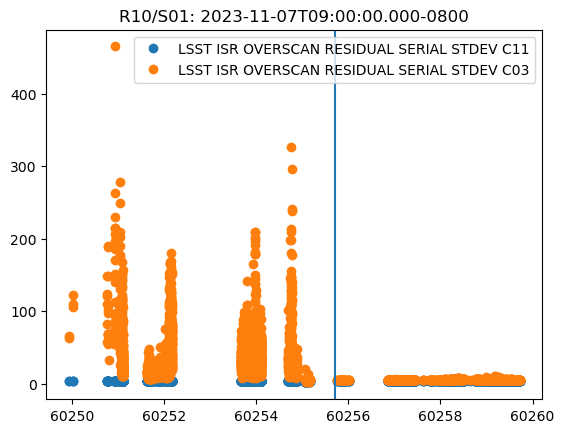

In [238]:
from astropy.time import Time
from dateutil.parser import parse  
for key in [
    "LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11",
    "LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C03"
    ]:
    pylab.plot(table["MJD"], table[key], "o",label=key)
localtime='2023-11-07T09:00:00.000-0800'
time=Time(parse(localtime))
pylab.axvline(time.mjd)
pylab.title(f"R10/S01: {localtime}")
pylab.legend()

In [15]:
import lsst.daf.butler as db

butler = db.Butler("/repo/ir2")

# Get collections:
collections = butler.registry.queryCollections("u/czw/*", datasetType="postISRCCD")

for coll in collections:
    refs = butler.registry.queryDatasets("postISRCCD.metadata", collections=coll)

    for datasetRef in list(refs):
        md = butler.get(datasetRef)
        print(datasetRef.dataId, [(k, v) for k,v in md.items() if "LSST ISR OVERSCAN RESIDUAL" in k])
# Example output: First is missing header keywords.  Second is truncated for length.
# {instrument: 'LSSTCam', detector: 82, exposure: 3023062100323, ...} []
# {instrument: 'LSSTCam', detector: 82, exposure: 3023062100323, ...} [('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C10', 0.403725903725908), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C10', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10', 3.68885404584418), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C11', -0.344072594072499), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C11', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11', 3.5113904656107),

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3548: FutureWarning: Querying for component datasets via Registry query methods is deprecated in favor of using DatasetRef and DatasetType methods on parent datasets. Only components=False will be supported after v26, and the components argument will be removed after v27.
  exec(code_obj, self.user_global_ns, self.user_ns)


{instrument: 'LSSTCam', detector: 82, exposure: 3023062100323, ...} []
{instrument: 'LSSTCam', detector: 1, exposure: 3023061900709, ...} [('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C10', 0.191734375000029), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C10', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C10', 3.54160812112624), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C11', 0.5166015625), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C11', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C11', 3.64867736258985), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C12', 0.224515624999963), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C12', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C12', 3.64697341878034), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C13', -0.217789062499739), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIAN C13', 0.0), ('LSST ISR OVERSCAN RESIDUAL SERIAL STDEV C13', 3.66884242425082), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEAN C14', -0.348624999999955), ('LSST ISR OVERSCAN RESIDUAL SERIAL MEDIA

In [22]:
table=list(registry.queryDatasets("raw", collections="LSSTCam/raw/all",
      where="instrument='LSSTCam' and exposure.science_program='13546'"))

In [38]:
reasons = []
for line in (registry.queryDimensionRecords( 'exposure',
    where=f"""instrument='LSSTCam'
    and exposure.science_program='13546'
    and exposure.observation_type='flat'
    """
    )):
    reasons.append(line.observation_reason)
set(reasons)

{'bot_persistence', 'flat', 'lambda', 'sflat_hi', 'sflat_lo'}

In [ ]:

where = "exposure.science_program = '13555' and detector=30 and exposure.observation_type!='bias'"

refs = list(set(butler.registry.queryDatasets('raw', where=where)))

histarr = []
binsarr = []

for ref in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
    img=butler.get(ref)
    hist,bins=numpy.histogram(img.image.array,range=(25e3,120e3),bins=95000)
    histarr.append(hist)
    binsarr.append(bins)
    pylab.plot((bins[1:]+bins[:-1])/2,hist,alpha=0.2)

pylab.plot((bins[1:]+bins[:-1])/2,numpy.sum(histarr,axis=0)/4)

pylab.title(where)
#pylab.ylim(0,20000)
pylab.xlabel("ADU")
pylab.ylabel("Frequency/ADU")
pylab.semilogy()

In [37]:
collections = butler.registry.queryCollections("*", datasetType="raw")

#where = "instrument = 'LSST-TS8' and exposure.science_program = '13573' and detector=30"
where = "instrument = 'LSST-TS8' and exposure.day_obs = 20231120" # and detector=30"

refs = list(set(butler.registry.queryDatasets('photodiode', where=where, collections=collections)))
print(len(refs))

fsspec_kwargs = {
    "default_block_size": 100000,
    "default_cache_type": "bytes",
    "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
}

print(butler.getURI(refs[1]).geturl())
with fits.open(butler.getURI(refs[1]).geturl(),use_fsspec=True,
      fsspec_kwargs = fsspec_kwargs
     ) as fh:
    md = fh[0].header


98
file:///sdf/group/rubin/repo/ir2/LSST-TS8/photodiode/photodiode/20231120/i/SDSSi/TS_C_20231120_000124/photodiode_LSST-TS8_i_SDSSi_TS_C_20231120_000124_LSST-TS8_photodiode.fits


In [15]:
import s3fs
s3fs.__version__

'2023.10.0'

In [35]:
#!/home/y/youtsumi/src/mutils/trendutils/trender.py --match 'focal-plane/R../.*Temp'
#!/home/y/youtsumi/src/mutils/trendutils/trender.py --start "2023/11/13 14:30" --text --dur 2h 'focal-plane/R../Reb./Temp2' --site slac

In [34]:
from astropy.io import ascii
ascii.read(output)

col1,col2,col3,col4,col5
int64,float64,str4,str19,str29
1697207402093,8e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:02.093-07:00
1697207412094,6e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:12.094-07:00
1697207422092,6e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:22.092-07:00
1697207432076,6e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:32.076-07:00
1697207442076,7e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:42.076-07:00
1697207452097,7e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:30:52.097-07:00
1697207462096,7e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:31:02.096-07:00
1697207472194,6e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:31:12.194-07:00
1697207482073,7e-05,Torr,vacuum/Cryo/CryoVac,2023-10-13T07:31:22.073-07:00


In [69]:
repo = '/repo/ir2'
acq_run = 13505
weekly = 'w_2023_41'
filt ="red"

collections = [f'u/lsstccs/eo_raft_lambda_mosaics_{acq_run}_{weekly}']
butler = Butler(repo, collections=collections)
refs = butler.registry.queryDatasets('postISRCCD', instrument="LSSTCam",
    where = (f"exposure.science_program='{acq_run}' AND exposure.observation_reason='lambda' AND detector=10")) # AND physical_filter='{filt}'"))
for aref in refs:
    print(aref.dataId.to_json())

{"dataId": {"band": "g", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~blue", "exposure": 2023110300764}}
{"dataId": {"band": "i", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~nm750", "exposure": 2023110300765}}
{"dataId": {"band": "r", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~red", "exposure": 2023110300766}}
{"dataId": {"band": "u", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~uv", "exposure": 2023110300767}}
{"dataId": {"band": "y", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~nm960", "exposure": 2023110300768}}
{"dataId": {"band": "z", "instrument": "LSSTCam", "detector": 10, "physical_filter": "ef_43~nm850", "exposure": 2023110300769}}
